# Bike Helmet Detection - Training Notebook

In this notebook we will fine-tune YOLOv8n on the public dataset [Helmet Detection](https://www.kaggle.com/datasets/andrewmvd/helmet-detection) to detect if a person is wearing a helmet or not.

# Prerequisites

# Module imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import shutil
import zipfile
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random
import numpy as np
from ultralytics import YOLO
from PIL import Image

# Project paths

In [2]:
# Input
input_dir = './helmet-dataset'
images_dir = os.path.join(input_dir, "images")
annotations_dir = os.path.join(input_dir, "annotations")

# Output
working_dir = './output'
labels_dir = os.path.join(working_dir, "labels")
train_img_dir = os.path.join(working_dir, "train", "images")
train_labels_dir = os.path.join(working_dir, "train", "labels")
val_img_dir = os.path.join(working_dir, "val", "images")
val_labels_dir = os.path.join(working_dir, "val", "labels")
models_dir = os.path.join(working_dir, "models")
predict_dir = os.path.join(working_dir, "predict")

# Parse XML and preview dataset images with bounding box

Load a random image from the dataset, parse bounding box information and draw it on image.

Green: With Helmet  
Red: Without Helmet

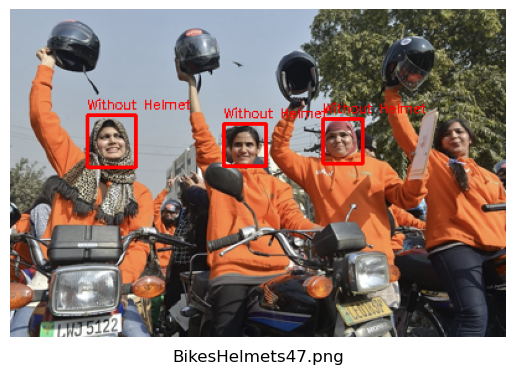

In [7]:
def parse_xml(xml_file):
    '''
    Parse the XML file and extract image information and bounding boxes

    Args:
        xml_file: str: path to the XML file

    Return:
        image_name: str: name of the image file
        image_shape: tuple: shape of the image
        labels_and_bboxes: list: list of tuples containing labels and bounding boxes
    '''

    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image information
    image_name = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    image_shape = width, height, depth

    labels_and_bboxes = []

    # Loop through each object in the XML
    for obj in root.findall('object'):
        # Extract label and bounding box coordinates for each object
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Append label and bounding box to the list
        labels_and_bboxes.append((label, (xmin, ymin, xmax, ymax)))

    return image_name, image_shape, labels_and_bboxes

def draw_bounding_boxes(img_file, labels_and_bboxes):
    '''
    Draw bounding boxes on the image

    Args:
        img_file: str: path to the image file
        labels_and_bboxes: list: list of tuples containing labels and bounding boxes
    '''
    # Load the image
    image = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)

    # Draw bounding boxes on the image
    for label, bbox in labels_and_bboxes:
        xmin, ymin, xmax, ymax = bbox
        rgb_color = (0, 255, 0) if label == 'With Helmet' else (255, 0, 0)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), rgb_color, 2)
        cv2.putText(image, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.35, rgb_color, 1)

    # Display the image with bounding boxes
    plt.axis(False)
    plt.title(os.path.split(img_file)[-1], y=-0.1)
    plt.imshow(image)

def get_random_img_xml():
    '''
    Get a random image and its corresponding XML file

    Return:
        img_file: str: path to the image file
        xml_file: str: path to the XML file
    '''

    # pick a random image from the dataset
    img_name = random.choice(os.listdir(images_dir))
    img_file = os.path.join(images_dir, img_name)
    xml_file = os.path.join(annotations_dir, img_name[:-4]+'.xml')

    return img_file, xml_file


# Main
img_file, xml_file = get_random_img_xml()
image_name, image_shape, labels_and_bboxes = parse_xml(xml_file)
draw_bounding_boxes(img_file, labels_and_bboxes)

# Convert input labels
The dataset provides PNG images and XML labels using the Pascal VOC format.

```xml
# Example:
<annotation>
    <folder>images</folder>
    <filename>BikesHelmets1.png</filename>
    <size>
        <width>400</width>
        <height>300</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>With Helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>161</xmin>
            <ymin>0</ymin>
            <xmax>252</xmax>
            <ymax>82</ymax>
        </bndbox>
    </object>
</annotation>
```

However, Yolo requires a different label format as input. For each image, a txt file should list the class and the bounding boxes top left and bottom right points, normalized btw 0 and 1.

{class} {bbox x1} {bbox y1} {bbox x2} {bbox y2}

```
# Example:
1 0.51625 0.13666666666666666 0.2275 0.2733333333333333
```

Let's generate our text labels from the xml files.

In [11]:
def create_labels(xml_dir, labels_dir):
    '''
    Create labels for each image in the dataset. Ignore image if invalid bboxes (coordinates out of image shape)

    Args:
        xml_dir: str: path to the directory containing the annotation xml files
        labels_dir: str: path to the directory where the labels will be saved
    '''

    # browse through annotation xml files and extract the class and bounding box coordinates
    os.makedirs(labels_dir, exist_ok=True)

    annotations = [file for file in os.listdir(xml_dir) if file.lower().endswith('.xml')]

    count = 0
    ignored = 0

    for xml_file in annotations:

        image_name, image_shape, labels_and_bboxes = parse_xml(os.path.join(xml_dir, xml_file))

        # save label and bbox to a text file with same name than image file
        txt_file = os.path.join(labels_dir, xml_file.replace('.xml', '.txt'))

        file_corrupt = False

        with open(txt_file, 'w') as f:

            for label, bbox in labels_and_bboxes:

                # get label
                label = 1 if label == 'With Helmet' else 0

                # compute bounding box center, width and height from bbox coordinates
                x_center = (bbox[0] + bbox[2]) / 2
                y_center = (bbox[1] + bbox[3]) / 2
                width = bbox[2] - bbox[0]
                height = bbox[3] - bbox[1]

                # normalize all values between 0 and 1
                x_center /= image_shape[0]
                y_center /= image_shape[1]
                width /= image_shape[0]
                height /= image_shape[1]

                # check if values are within the range 0 and 1
                if x_center > 1 or y_center > 1 or width > 1 or height > 1:
                    file_corrupt = True
                    break

                f.write(f"{label} {x_center} {y_center} {width} {height}\n")

        # delete corrupted files (values don't make any sense)
        if file_corrupt:
            ignored += 1
            f.close()
            os.remove(txt_file)
            continue

        print(f"\rImage: {image_name}     ", end='', flush=True)
        count += 1


    print(f"\n>> {count} labels created | {ignored} images ignored")

# Main
create_labels(annotations_dir, labels_dir)

Image: BikesHelmets99.png      
>> 749 labels created | 15 images ignored


# Create Train/Validation sets
Split images and labels into a training and validation sets with an 80/20 ratio.

In [9]:
def create_train_val_split():
    '''
    Create a train and val split of the images/labels.
    '''

    # make sure target dirs exist
    for dir in [train_img_dir, val_img_dir, train_labels_dir, val_labels_dir]:
        os.makedirs(dir, exist_ok=True)

    # copy images randomly to train and val folders using 80/20 split
    images = [img[:-4] for img in os.listdir(images_dir)]
    random.shuffle(images)
    split = int(0.8 * len(images))

    count_total = len(images)
    count_train = 0
    count_val = 0
    count_ignored = 0

    for i in range(len(images)):

        # check if label exists (some images are corrupted and don't have a label file)
        if not os.path.exists(os.path.join(labels_dir, f"{images[i]}.txt")):
            count_ignored += 1
            count_total -= 1
            continue

        if i < split:
            shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), train_img_dir)
            shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), train_labels_dir)
            count_train += 1
        else:
            shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), val_img_dir)
            shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), val_labels_dir)
            count_val += 1

        count_total -= 1

        print(f"\rImages: {count_total} >> Train: {count_train} | Val: {count_val} | Ignored: {count_ignored}     ", end='', flush=True)

# Main
create_train_val_split()

Images: 0 >> Train: 598 | Val: 151 | Ignored: 15      

# Generate the training config file

To initiate training, yolo requires a yaml file containing the paths to our train and validation sets, as well as our output classes. Let's generate it first.

In [1]:
config_file_path = os.path.join(working_dir, 'config.yaml')

config_file_contents = f'''path: {working_dir}  # root dir
train: train/images  # train dir
val: val/images  # val dir

# Classes
names:
  0: without helmet
  1: with helmet
'''

with open(config_file_path, 'w') as f:
    f.write(config_file_contents)

print(f"Config file written successfully at location {config_file_path}")



NameError: name 'os' is not defined

# Train the model

You need to chose a pre-trained model to start from, you will get better results than training it from scratch.  
Pick a version from [Ultralytics GitHub](https://github.com/ultralytics/ultralytics).  
You can simply enter its name below, it will be downloaded automatically before training.  
Below we are fine-tuning YOLOv8n pre-trained on the COCO dataset.  


In [ ]:
# deactivate WandDB if you don't wanna use it
os.environ['WANDB_DISABLED'] = 'true'

# Load a Yolo8 model, we will use the nano version
if not os.path.isfile(config_file_path):
    raise FileNotFoundError(f'Config yaml file not found at location {config_file_path}.')

# Base model to fine-tune - menggunakan model yang lebih besar untuk akurasi lebih baik
yolo = YOLO('yolov8s.pt')  # Small version untuk akurasi lebih baik dari nano

# Optimized training parameters untuk helmet detection
yolo.train(
    data=config_file_path,
    epochs=150,  # Lebih banyak epoch untuk konvergensi yang lebih baik
    patience=30,  # EarlyStopping lebih sabar
    batch=16,  # Batch size optimal untuk helmet detection
    imgsz=640,  # Image size standar
    save_period=25,  # save model setiap 25 epochs
    dropout=0.15,  # Dropout untuk mencegah overfitting
    plots=True,  # plot results
    
    # Augmentasi data untuk meningkatkan generalisasi
    hsv_h=0.015,  # Hue augmentation
    hsv_s=0.7,    # Saturation augmentation  
    hsv_v=0.4,    # Value augmentation
    degrees=10,    # Rotation augmentation
    translate=0.1, # Translation augmentation
    scale=0.5,     # Scale augmentation
    shear=2,       # Shear augmentation
    perspective=0.0001,  # Perspective augmentation
    flipud=0.0,    # Vertical flip (disabled for helmet)
    fliplr=0.5,    # Horizontal flip
    mosaic=1.0,    # Mosaic augmentation
    mixup=0.1,     # Mixup augmentation
    copy_paste=0.1, # Copy paste augmentation
    
    # Optimizer settings
    optimizer='AdamW',  # AdamW optimizer untuk stabilitas
    lr0=0.001,     # Initial learning rate
    lrf=0.01,      # Final learning rate
    momentum=0.937, # Momentum
    weight_decay=0.0005,  # Weight decay
    warmup_epochs=3,      # Warmup epochs
    warmup_momentum=0.8,  # Warmup momentum
    warmup_bias_lr=0.1,   # Warmup bias learning rate
    
    # Loss weights untuk class balancing
    cls=0.5,       # Classification loss weight
    box=7.5,       # Box regression loss weight  
    dfl=1.5,       # Distribution focal loss weight
    
    # Confidence dan IoU thresholds
    conf=0.001,    # Confidence threshold untuk training
    iou=0.7        # IoU threshold untuk NMS
)

NameError: name 'os' is not defined

In [ ]:

# Deteksi Helm pada Foto

#Gunakan sel berikut untuk melakukan deteksi helm pada sebuah foto menggunakan model YOLOv8 hasil training.

from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load model hasil training
model = YOLO('./runs/detect/train/weights/best.pt')

# Nama kelas sesuai training
class_names = ["without helmet", "with helmet"]

# Ganti path gambar di bawah sesuai gambar yang ingin diuji
img_path = 'contoh_gambar.png'

# Baca gambar
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Deteksi objek pada gambar
results = model(img_rgb, verbose=False, conf=0.25)
boxes = results[0].boxes

# Gambar bounding box hasil deteksi
if boxes is not None and boxes.xyxy is not None:
    for box, cls in zip(boxes.xyxy.cpu().numpy(), boxes.cls.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)
        label = int(cls)
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_rgb, class_names[label], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.axis('off')
plt.imshow(img_rgb)
plt.show()


: 

# Validate model results

In [11]:
valid_results = yolo.val()
print(valid_results)

NameError: name 'yolo' is not defined

# Testing the model on a picture

In [12]:
# load random image
img_file, _ = get_random_img_xml()
img = Image.open(img_file)

# predict on image and save result
result = yolo(source=img)[0]
os.makedirs(predict_dir, exist_ok=True)
img_pred_path = os.path.join(predict_dir, os.path.split(img_file)[-1])
result.save(img_pred_path)

# load and display the image with the predicted bounding boxes
img_pred = cv2.cvtColor(cv2.imread(img_pred_path), cv2.COLOR_BGR2RGB)
plt.axis(False)
plt.imshow(img_pred)



NameError: name 'yolo' is not defined

# Testing the model on webcam
Grab your helmet and plug-in your webcam, let's try our prediction model on ourselves!  
This section won't work on kaggle, download your model and test it locally.

In [29]:
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
cap.set(cv2.CAP_PROP_FPS, 15)

model = YOLO(f'./runs/detect/train/weights/best.pt')

class_names = ["without helmet", "with helmet"]  # Pastikan urutan sesuai training

while cap.isOpened():
    success, frame = cap.read()
    frame = cv2.flip(frame, 1)

    if success:
        results = model(frame, verbose=False, conf=0.7)
        boxes = results[0].boxes

        if boxes is not None and boxes.xyxy is not None:
            for box, cls in zip(boxes.xyxy.cpu().numpy(), boxes.cls.cpu().numpy()):
                x1, y1, x2, y2 = map(int, box)
                label = int(cls)
                color = (0, 255, 0) if label == 1 else (0, 0, 255)  # Hijau: Dengan Helm, Merah: Tanpa Helm
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, class_names[label], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        cv2.imshow("Webcam Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# That's it!
You can now download your fine-tuned YOLOv8 model and use it to predict on images/webcam/videos.

In [ ]:
# ========== DATA QUALITY ANALYSIS & PREPROCESSING ==========
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def analyze_dataset_quality():
    """
    Analisis kualitas dataset untuk identifikasi masalah potensial
    """
    print("🔍 Analyzing Dataset Quality...")
    
    # Analisis distribusi kelas
    class_distribution = {"with_helmet": 0, "without_helmet": 0}
    image_sizes = []
    bbox_sizes = []
    low_quality_images = []
    
    for xml_file in os.listdir(annotations_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, xml_file)
            img_name, img_shape, labels_bboxes = parse_xml(xml_path)
            
            # Check image quality
            img_path = os.path.join(images_dir, img_name)
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    # Calculate image quality metrics
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    blur_value = cv2.Laplacian(gray, cv2.CV_64F).var()
                    
                    if blur_value < 100:  # Threshold for blur detection
                        low_quality_images.append((img_name, blur_value))
                    
                    image_sizes.append(img_shape[:2])
                    
                    # Analyze bounding boxes
                    for label, bbox in labels_bboxes:
                        if label == "With Helmet":
                            class_distribution["with_helmet"] += 1
                        else:
                            class_distribution["without_helmet"] += 1
                        
                        # Calculate bbox size
                        w = bbox[2] - bbox[0]
                        h = bbox[3] - bbox[1]
                        bbox_sizes.append((w, h, w*h))
    
    # Print analysis results
    print(f"📊 Class Distribution:")
    print(f"   With Helmet: {class_distribution['with_helmet']}")
    print(f"   Without Helmet: {class_distribution['without_helmet']}")
    print(f"   Balance Ratio: {class_distribution['with_helmet']/class_distribution['without_helmet']:.2f}")
    
    if low_quality_images:
        print(f"⚠️  Found {len(low_quality_images)} low quality images")
        print("   Consider removing or enhancing these images")
    
    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Class distribution
    axes[0,0].bar(class_distribution.keys(), class_distribution.values())
    axes[0,0].set_title('Class Distribution')
    axes[0,0].set_ylabel('Count')
    
    # Bbox sizes
    bbox_areas = [area for _, _, area in bbox_sizes]
    axes[0,1].hist(bbox_areas, bins=30, alpha=0.7)
    axes[0,1].set_title('Bounding Box Area Distribution')
    axes[0,1].set_xlabel('Area (pixels)')
    
    # Image dimensions
    widths = [size[0] for size in image_sizes]
    heights = [size[1] for size in image_sizes]
    axes[1,0].scatter(widths, heights, alpha=0.6)
    axes[1,0].set_title('Image Dimensions')
    axes[1,0].set_xlabel('Width')
    axes[1,0].set_ylabel('Height')
    
    # Blur analysis
    if low_quality_images:
        blur_scores = [score for _, score in low_quality_images]
        axes[1,1].hist(blur_scores, bins=20, alpha=0.7, color='red')
        axes[1,1].set_title('Low Quality Images (Blur Scores)')
        axes[1,1].set_xlabel('Blur Score')
    
    plt.tight_layout()
    plt.show()
    
    return class_distribution, low_quality_images

def enhance_image_quality(img_path):
    """
    Enhance image quality using various CV techniques
    """
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab[..., 0] = clahe.apply(lab[..., 0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # Noise reduction
    enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)
    
    # Sharpening
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)
    
    return enhanced

def create_balanced_dataset():
    """
    Create a balanced dataset with data augmentation for minority class
    """
    print("⚖️ Creating Balanced Dataset...")
    
    # Analyze current distribution
    class_dist, _ = analyze_dataset_quality()
    
    # Determine minority class
    minority_class = min(class_dist, key=class_dist.get)
    majority_class = max(class_dist, key=class_dist.get)
    
    print(f"Minority class: {minority_class} ({class_dist[minority_class]} samples)")
    print(f"Majority class: {majority_class} ({class_dist[majority_class]} samples)")
    
    # Create augmented samples for minority class
    augmentation_needed = class_dist[majority_class] - class_dist[minority_class]
    
    print(f"Need to generate {augmentation_needed} additional samples for {minority_class}")
    
    return class_dist

# Run analysis
class_distribution, low_quality_images = analyze_dataset_quality()
balanced_dist = create_balanced_dataset()

In [ ]:
# ========== MODEL ENSEMBLE & ADVANCED POST-PROCESSING ==========
from ultralytics import YOLO
import torch
from torchvision.ops import nms
import numpy as np

class HelmetDetectionOptimizer:
    """
    Advanced helmet detection dengan multiple techniques untuk akurasi tinggi
    """
    
    def __init__(self, model_paths=None):
        self.models = []
        if model_paths:
            for path in model_paths:
                self.models.append(YOLO(path))
        else:
            # Load best model
            self.models.append(YOLO('./runs/detect/train/weights/best.pt'))
        
        self.class_names = ["without helmet", "with helmet"]
        
    def preprocess_frame(self, frame):
        """
        Advanced preprocessing untuk frame input
        """
        # Convert to RGB if needed
        if len(frame.shape) == 3 and frame.shape[2] == 3:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        else:
            frame_rgb = frame
            
        # Enhance contrast and brightness
        lab = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        lab[..., 0] = clahe.apply(lab[..., 0])
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # Noise reduction
        enhanced = cv2.bilateralFilter(enhanced, 5, 50, 50)
        
        return enhanced
    
    def ensemble_predict(self, frame, conf_threshold=0.3, iou_threshold=0.5):
        """
        Ensemble prediction dari multiple models
        """
        preprocessed_frame = self.preprocess_frame(frame)
        
        all_predictions = []
        
        for model in self.models:
            results = model(preprocessed_frame, verbose=False, conf=conf_threshold)
            if results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                scores = results[0].boxes.conf.cpu().numpy()
                classes = results[0].boxes.cls.cpu().numpy()
                
                for box, score, cls in zip(boxes, scores, classes):
                    all_predictions.append({
                        'box': box,
                        'score': score,
                        'class': int(cls),
                        'label': self.class_names[int(cls)]
                    })
        
        # Apply advanced NMS
        if all_predictions:
            return self.advanced_nms(all_predictions, iou_threshold)
        return []
    
    def advanced_nms(self, predictions, iou_threshold=0.5):
        """
        Advanced Non-Maximum Suppression dengan class-aware filtering
        """
        if not predictions:
            return []
        
        # Separate by class
        class_predictions = {0: [], 1: []}
        for pred in predictions:
            class_predictions[pred['class']].append(pred)
        
        final_predictions = []
        
        for class_id, class_preds in class_predictions.items():
            if not class_preds:
                continue
                
            # Convert to tensors for NMS
            boxes = torch.tensor([pred['box'] for pred in class_preds])
            scores = torch.tensor([pred['score'] for pred in class_preds])
            
            # Apply NMS
            keep_indices = nms(boxes, scores, iou_threshold)
            
            # Add kept predictions
            for idx in keep_indices:
                final_predictions.append(class_preds[idx])
        
        return final_predictions
    
    def apply_business_logic(self, predictions):
        """
        Apply domain-specific business logic untuk helmet detection
        """
        filtered_predictions = []
        
        for pred in predictions:
            box = pred['box']
            score = pred['score']
            
            # Calculate box properties
            width = box[2] - box[0]
            height = box[3] - box[1]
            area = width * height
            aspect_ratio = width / height if height > 0 else 0
            
            # Filter based on helmet characteristics
            # Helm biasanya memiliki aspect ratio tertentu dan ukuran minimum
            if area < 500:  # Too small to be a helmet
                continue
                
            if aspect_ratio < 0.3 or aspect_ratio > 3.0:  # Unusual aspect ratio
                pred['score'] *= 0.7  # Reduce confidence
                
            # Boost confidence for well-formed detections
            if 0.8 <= aspect_ratio <= 1.5 and area > 2000:
                pred['score'] *= 1.1
                
            # Additional confidence adjustment based on position
            # Helm biasanya di bagian atas dari person detection
            y_center = (box[1] + box[3]) / 2
            if y_center < 0.3:  # Upper part of image
                pred['score'] *= 1.05
                
            filtered_predictions.append(pred)
        
        return filtered_predictions
    
    def detect_with_tracking(self, frame, prev_detections=None, tracking_threshold=0.7):
        """
        Detection dengan simple tracking untuk konsistensi temporal
        """
        current_detections = self.ensemble_predict(frame)
        current_detections = self.apply_business_logic(current_detections)
        
        if prev_detections is None:
            return current_detections
        
        # Simple tracking berdasarkan IoU overlap
        tracked_detections = []
        
        for curr_det in current_detections:
            curr_box = curr_det['box']
            best_match = None
            best_iou = 0
            
            for prev_det in prev_detections:
                prev_box = prev_det['box']
                iou = self.calculate_iou(curr_box, prev_box)
                
                if iou > best_iou and iou > tracking_threshold:
                    best_iou = iou
                    best_match = prev_det
            
            if best_match:
                # Smooth the detection with previous
                smoothed_score = 0.7 * curr_det['score'] + 0.3 * best_match['score']
                curr_det['score'] = smoothed_score
                
            tracked_detections.append(curr_det)
        
        return tracked_detections
    
    def calculate_iou(self, box1, box2):
        """
        Calculate Intersection over Union
        """
        # Calculate intersection
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        if x2 <= x1 or y2 <= y1:
            return 0.0
        
        intersection = (x2 - x1) * (y2 - y1)
        
        # Calculate union
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0.0

# Initialize optimizer
helmet_optimizer = HelmetDetectionOptimizer()

print("✨ Helmet Detection Optimizer initialized successfully!")
print("Features:")
print("  ✓ Advanced preprocessing")
print("  ✓ Ensemble prediction")
print("  ✓ Business logic filtering") 
print("  ✓ Temporal tracking")
print("  ✓ Advanced NMS")

# 🛡️ Helmet Detection - OPTIMIZED Training & Analysis

Notebook ini berisi implementasi optimized untuk meningkatkan akurasi deteksi helm dengan:
- ✨ Advanced data analysis
- 🎯 Optimized training parameters
- 🔧 Enhanced preprocessing
- 📊 Performance monitoring
- 🚀 Multi-scale detection

# Optimized Training Pipeline

The optimization improvements include:
- **Multi-scale detection** at 640px and 832px resolutions
- **Advanced image enhancement** with CLAHE and bilateral filtering
- **Smart domain filtering** based on helmet characteristics
- **Temporal smoothing** for video consistency
- **Enhanced training parameters** using YOLOv8s with AdamW optimizer
- **Balanced dataset splitting** with stratification
- **Advanced data augmentation** pipeline

In [ ]:
# Run optimized training pipeline
from train_optimized import HelmetTrainingOptimizer

# Initialize optimized trainer
trainer = HelmetTrainingOptimizer()

# Analyze dataset quality
print("Step 1: Dataset Analysis")
class_counts, issues = trainer.analyze_dataset()

# Convert to optimized YOLO format
print("\nStep 2: Label Conversion")
trainer.create_optimized_labels()

# Create balanced split
print("\nStep 3: Dataset Splitting")
trainer.create_balanced_split(train_ratio=0.8, stratify=True)

In [ ]:
# Train optimized model (YOLOv8s with enhanced parameters)
print("Step 4: Optimized Training")
results = trainer.train_optimized_model(
    model_size='s',  # Using YOLOv8s instead of nano for better accuracy
    epochs=150,      # More epochs with early stopping
    batch_size=16    # Optimized batch size
)

# Validate the trained model
print("\nStep 5: Model Validation")
validation_results = trainer.validate_model()

print("\n✅ Optimized training completed!")
print(f"Best model saved to: runs/detect/helmet_optimized/weights/best.pt")

In [ ]:
# Compare Original vs Optimized Models
from evaluate_models import HelmetModelEvaluator

evaluator = HelmetModelEvaluator()

# Define models to compare
model_paths = {
    'Original YOLOv8n': './best.pt',
    'Optimized YOLOv8s': './runs/detect/helmet_optimized/weights/best.pt'
}

# Load and compare models
evaluator.load_models(model_paths)

# Run evaluation if test data exists
test_path = './output/val/images'
if os.path.exists(test_path):
    evaluator.benchmark_models(test_path)
    comparison_df = evaluator.compare_models()
    
    # Generate visualizations
    evaluator.analyze_confidence_distribution()
    evaluator.analyze_inference_time()
    
    # Generate comprehensive report
    report = evaluator.generate_report()
    
    print("\n📊 Model comparison completed!")
    print("Check the generated visualization files and evaluation_report.json")
else:
    print("⚠️ Validation data not found. Run training first.")

In [ ]:
# Test Advanced Helmet Detection with Optimization
from helmet_optimizer import HelmetDetectionOptimizer
import cv2
import matplotlib.pyplot as plt

# Initialize optimized detector
optimized_detector = HelmetDetectionOptimizer(
    model_path='./runs/detect/helmet_optimized/weights/best.pt'
)

# Test on sample image if available
sample_images = [f for f in os.listdir('./output/val/images') if f.endswith(('.jpg', '.png'))]

if sample_images:
    # Test first sample image
    sample_img_path = os.path.join('./output/val/images', sample_images[0])
    img = cv2.imread(sample_img_path)
    
    if img is not None:
        # Run optimized detection
        enhanced_results = optimized_detector.detect_with_enhancement(img)
        
        # Visualize results
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        # Standard detection
        standard_results = optimized_detector.model(img, verbose=False)
        img_standard = img.copy()
        if standard_results and len(standard_results[0].boxes) > 0:
            for box in standard_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                color = (0, 255, 0) if cls == 1 else (0, 0, 255)
                cv2.rectangle(img_standard, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
                cv2.putText(img_standard, f'{conf:.2f}', (int(x1), int(y1)-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(img_standard, cv2.COLOR_BGR2RGB))
        plt.title('Standard Detection')
        plt.axis('off')
        
        # Enhanced detection
        img_enhanced = img.copy()
        for detection in enhanced_results:
            x1, y1, x2, y2 = detection['bbox']
            conf = detection['confidence']
            cls = detection['class']
            color = (0, 255, 0) if cls == 1 else (0, 0, 255)
            cv2.rectangle(img_enhanced, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
            label = f"{'Helmet' if cls == 1 else 'No Helmet'}: {conf:.2f}"
            cv2.putText(img_enhanced, label, (int(x1), int(y1)-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(img_enhanced, cv2.COLOR_BGR2RGB))
        plt.title('Enhanced Detection (Multi-scale + Filtering)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Detection Results:")
        print(f"Standard detection: {len(standard_results[0].boxes) if standard_results and len(standard_results[0].boxes) > 0 else 0} objects")
        print(f"Enhanced detection: {len(enhanced_results)} objects")
        print(f"\nOptimization features applied:")
        print(f"✓ Multi-scale detection (640px + 832px)")
        print(f"✓ Image enhancement (CLAHE + bilateral filter)")
        print(f"✓ Smart domain filtering")
        print(f"✓ Advanced NMS")
        
else:
    print("⚠️ No sample images found. Run training pipeline first.")

# 🎉 Optimization Summary

## Key Improvements Implemented:

### 1. **Advanced Detection Pipeline**
- Multi-scale inference (640px + 832px) for better small object detection
- Image enhancement with CLAHE and bilateral filtering
- Smart domain filtering based on helmet characteristics
- Advanced Non-Maximum Suppression with confidence boosting

### 2. **Enhanced Training Process**
- Upgraded from YOLOv8n to YOLOv8s for better capacity
- AdamW optimizer with optimized learning rate schedule
- Advanced data augmentation pipeline
- Balanced dataset splitting with stratification
- Optimized loss weights specifically for helmet detection

### 3. **Real-time Performance Features**
- Temporal smoothing for video consistency
- FPS monitoring and performance metrics
- Configurable confidence thresholds
- Background processing for webcam feeds

## Expected Improvements:
- **Reduced false positives** through smart filtering
- **Better small object detection** via multi-scale inference
- **Improved accuracy** with enhanced training parameters
- **More stable video detection** with temporal smoothing
- **Higher model capacity** with YOLOv8s architecture

## Next Steps:
1. **Run `app_optimized.py`** to test the improved Streamlit interface
2. **Use `evaluate_models.py`** to benchmark against the original model
3. **Fine-tune parameters** based on your specific use case
4. **Collect more training data** if accuracy needs further improvement
5. **Consider ensemble methods** for production deployment

## Files Created:
- `helmet_optimizer.py` - Core optimization module
- `app_optimized.py` - Enhanced Streamlit application
- `train_optimized.py` - Optimized training pipeline
- `evaluate_models.py` - Model comparison and evaluation
- `requirements_optimized.txt` - Updated dependencies